In [1]:
!pip install imutils

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import library

In [3]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 10
    num_classes = 29
    img_channels = 3

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [5]:
# Labels
TRAIN_PATH = "/content/drive/MyDrive/ИИ/train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet[0:3])
print(labels)

['A', 'B', 'C']


In [6]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

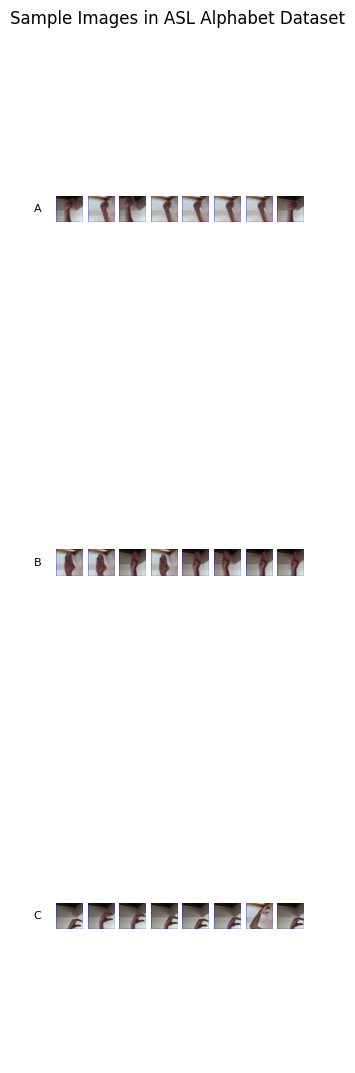

In [7]:
sample_images(labels[:10])

In [8]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,/content/drive/MyDrive/ИИ/train/A/A2006.jpg,A
1,/content/drive/MyDrive/ИИ/train/A/A1990.jpg,A
2,/content/drive/MyDrive/ИИ/train/A/A2001.jpg,A
3,/content/drive/MyDrive/ИИ/train/A/A1992.jpg,A
4,/content/drive/MyDrive/ИИ/train/A/A1995.jpg,A
...,...,...
4498,/content/drive/MyDrive/ИИ/train/C/C1973.jpg,C
4499,/content/drive/MyDrive/ИИ/train/C/C1990.jpg,C
4500,/content/drive/MyDrive/ИИ/train/C/C1987.jpg,C
4501,/content/drive/MyDrive/ИИ/train/C/C1983.jpg,C


In [9]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=0.15,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

,image_path,label
4376,/content/drive/MyDrive/ИИ/train/C/C1891.jpg,C
3748,/content/drive/MyDrive/ИИ/train/C/C2764.jpg,C
1570,/content/drive/MyDrive/ИИ/train/B/B2070.jpg,B
2431,/content/drive/MyDrive/ИИ/train/B/B2943.jpg,B
1953,/content/drive/MyDrive/ИИ/train/B/B2448.jpg,B
...,...,...
430,/content/drive/MyDrive/ИИ/train/A/A2435.jpg,A
1097,/content/drive/MyDrive/ИИ/train/A/A1578.jpg,A
4065,/content/drive/MyDrive/ИИ/train/C/C1549.jpg,C
2829,/content/drive/MyDrive/ИИ/train/B/B1813.jpg,B


,image_path,label
347,/content/drive/MyDrive/ИИ/train/A/A2364.jpg,A
3827,/content/drive/MyDrive/ИИ/train/C/C2826.jpg,C
3762,/content/drive/MyDrive/ИИ/train/C/C2766.jpg,C
2487,/content/drive/MyDrive/ИИ/train/B/B3000.jpg,B
3246,/content/drive/MyDrive/ИИ/train/C/C2252.jpg,C
...,...,...
250,/content/drive/MyDrive/ИИ/train/A/A2266.jpg,A
1019,/content/drive/MyDrive/ИИ/train/A/A1507.jpg,A
1009,/content/drive/MyDrive/ИИ/train/A/A1506.jpg,A
1078,/content/drive/MyDrive/ИИ/train/A/A1598.jpg,A


,image_path,label
3404,/content/drive/MyDrive/ИИ/train/C/C2413.jpg,C
2958,/content/drive/MyDrive/ИИ/train/B/B1956.jpg,B
856,/content/drive/MyDrive/ИИ/train/A/A2865.jpg,A
4042,/content/drive/MyDrive/ИИ/train/C/C1530.jpg,C
3715,/content/drive/MyDrive/ИИ/train/C/C2690.jpg,C
...,...,...
3169,/content/drive/MyDrive/ИИ/train/C/C2179.jpg,C
3194,/content/drive/MyDrive/ИИ/train/C/C2187.jpg,C
212,/content/drive/MyDrive/ИИ/train/A/A2213.jpg,A
1721,/content/drive/MyDrive/ИИ/train/B/B2212.jpg,B


In [10]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [11]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 3006 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.
Found 676 validated image filenames belonging to 3 classes.


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,027,971 (61.14 MB)

 Trainable params: 1,313,283 (5.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None

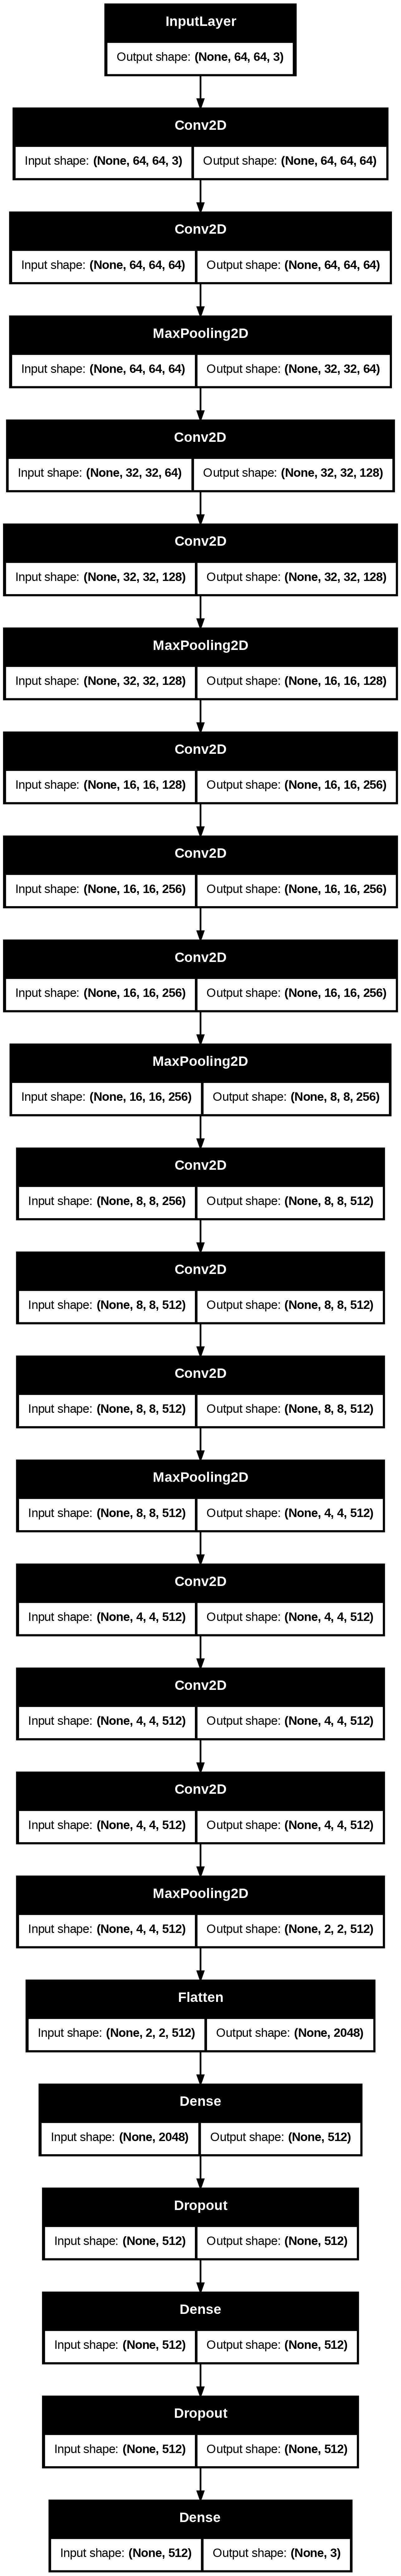

In [12]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

In [13]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint

# Callbacks
checkpoint = ModelCheckpoint(
    'asl_vgg16_best_weights.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True
)

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1112s 21s/step - accuracy: 0.6473 - loss: 0.7886 - val_accuracy: 0.9844 - val_loss: 0.0639
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 420ms/step - accuracy: 0.9688 - loss: 0.0875 - val_accuracy: 1.0000 - val_loss: 0.0390
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step - accuracy: 0.9663 - loss: 0.0865 - val_accuracy: 0.9948 - val_loss: 0.0185
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9531 - loss: 0.0606 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.9856 - loss: 0.0473 - val_accuracy: 0.9974 - val_loss: 0.0122
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0114
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - accuracy: 0.9905 - loss: 0.0186 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.1. Model Testing</h2>
</div>

In [ ]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

676/676 ━━━━━━━━━━━━━━━━━━━━ 208s 305ms/step - accuracy: 1.0000 - loss: 0.0015
Evaluate Test Accuracy: 100.00%


<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.2. Training Loss and Metrics</h2>
</div>

In [ ]:
# Visualize Training and Validation Results

# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy"],
)

# Configuration Plot
class PlotCFG:
    marker_size = 8
    line_size = 2
    train_color = "#76503d"
    valid_color = "#deb392"

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5,
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.3. Confusion Matrix</h2>
</div>

In [ ]:
model.save('asl_model.h5')

In [ ]:
# Confusion Matrix
fine_tuned_model = load_model("/content/asl_model.h5")
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

676/676 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


In [ ]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=labels,
        y=labels,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

In [ ]:
model.save('asl_model.h5')